In [724]:
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import pandas as pd
import re
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from collections import Counter
#from nltk.corpus import stopwords
import string
import operator
import seaborn as sns
from itertools import groupby
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
%matplotlib inline

In [725]:
with open("../out/juicers.json", "r") as f:
    allJuicers = json.load(f)

priceListByBrand = {}
rankListByBrand = {}
juicersByAsin = {}
for cat, juicers in allJuicers.items():
    for juicer in juicers:
        asin = list(juicer.keys())[0]
        val = list(juicer.values())[0]
        val.update({"category":cat})
        if any(x in val['title'].lower() for x in ['juice','juicer']):
            juicersByAsin.update({asin: val})
        else:
            continue
        brand = val['brand']
        try:
            if brand.lower() == 'breville juicer':
                brand = 'breville'
        except:
            continue

        try:
            if brand.lower() == 'omega juicers':
                brand = 'omega'
        except:
            continue
        try:
            priceListByBrand.setdefault(brand, []).append(float(val['price'][1:]))
        except:
            pass

        try:
            if not val['sales_rank'] == 'None':
                rankListByBrand.setdefault(brand, []).append(int(val['sales_rank']))
        except:
            pass

df_all = pd.DataFrame(juicersByAsin)

df_all = df_all.T

In [726]:
df_all.head()

,brand,category,color,features,price,sales_rank,title
B00004R93U,Juiceman,centrifugal,Off-White,[Peppy 1/4-horsepower motor quickly juices mos...,$158.98,1006304,Juiceman Jr. Elite Pro JM211 Juice Extractor
B00004R93V,Juiceman,centrifugal,White,[Powerful 1/2-horsepower motor quickly juices ...,$79.95,778846,The Juiceman Electronic Professional Series 41...
B00004S8FH,Waring,centrifugal,White,[Converts all noncitrus fruits and vegetables ...,$360.00,227195,"Waring PJE401 Juice Extractor, Quite White and..."
B00004S8FI,Waring,citrus,Quite White,"[Juices all citrus fruits, from limes to grape...",None,254788,"Waring PCJ201 Citrus Juicer, Quite White"
B00004S8FJ,Waring,citrus,Stainless Steel,"[Juices all citrus fruits, from limes to grape...",$149.99,231125,"Waring PCJ218 Citrus Juicer, Stainless Steel"


#### Let's check the general characteristics of the data

In [727]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1017 entries, B00004R93U to B0739LW3XS
Data columns (total 7 columns):
brand         1010 non-null object
category      1017 non-null object
color         839 non-null object
features      1017 non-null object
price         968 non-null object
sales_rank    1017 non-null object
title         1017 non-null object
dtypes: object(7)
memory usage: 63.6+ KB


Brand, categoty, color are categorical features. 
Price and sales_rank are numeric features. 
I am going to exclude "features" column as it is too complicated to use for the model for me for now.
This will be a clasification problem. I will try to make a model to predict the most successfull products in terms of the sales rank

In [728]:
df_all.isnull().sum()

brand           7
category        0
color         178
features        0
price          49
sales_rank      0
title           0
dtype: int64

There are some null data. There are also some hidden null data in str type, 'None' in sales_rank and color columns.

In [729]:
(df_all=='None').sum()

brand           0
category        0
color           1
features        0
price           0
sales_rank    252
title           0
dtype: int64

In [730]:
df_all.dtypes

brand         object
category      object
color         object
features      object
price         object
sales_rank    object
title         object
dtype: object

Convert these null data to float 'NaN' so that isnull() function can detect them

In [731]:
df_all[df_all == 'None'] = float('NaN')

In [732]:
df_all.isnull().sum()

brand           7
category        0
color         179
features        0
price          49
sales_rank    252
title           0
dtype: int64

Let's convert the price column to float

In [733]:
def getPrice(x):
    if x:
        x = x.replace(',','.')
        res = re.findall('\d+.\d+', x)
        if res:
            return float(res[0])
        else:
            return float('NaN')
    else:
        return x

In [734]:
df_all['price'] = df_all['price'].apply(getPrice)

Convert sales_rank column to float. Normally, I would use int. However, as the pandas doesnt have the ability to store NaN values as int, I used float.
ref. https://stackoverflow.com/a/21290084

In [735]:
df_all['sales_rank'] = df_all['sales_rank'].astype(float)

In [736]:
df_all.dtypes

brand          object
category       object
color          object
features       object
price         float64
sales_rank    float64
title          object
dtype: object

In [741]:
df_all['color'] = df_all['color'].str.lower()

In [754]:
def correct_typo(s):
    if type(s) == str:
        typo = {"sliver": "silver", "golden": "gold", "balck": "black", "sless": "stainless"}
        for k, v in typo.items():
            s = s.replace(k, v)
    return s

In [755]:
df_all['color'] = df_all['color'].apply(correct_typo)

In [756]:
def correct_brands(s):
    if type(s) == str:
        typo = {"Breville Juicer": "Breville", "Omega Juicers": "Omega"}
        for k, v in typo.items():
            s = s.replace(k, v)
    return s

In [757]:
df_all['brand'] = df_all['brand'].apply(correct_brands)

### Exploratary Data Visualization

In [740]:
# classification problem. Find the importance of features to be in the first 25% in sales rank
df_all.describe()

,price,sales_rank
count,953.000000,7.650000e+02
mean,215.676677,6.368142e+05
std,226.423316,6.210059e+05
min,1.019000,3.190000e+02
25%,39.950000,1.501720e+05
50%,119.920000,4.280410e+05
75%,345.950000,1.004701e+06
max,999.000000,5.004443e+06


There is a negative correlation between price and the sales rank especially for the prices greater than $100

,sales_rank,price
sales_rank,1.000000,0.117416
price,0.117416,1.000000


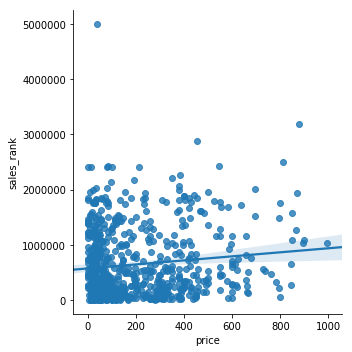

In [796]:
sns.lmplot(data=df_all, x='price', y='sales_rank')
df_all[['sales_rank', 'price']].corr()

,sales_rank,price
sales_rank,1.000000,0.202261
price,0.202261,1.000000


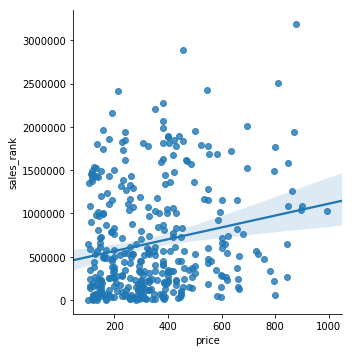

In [798]:
sns.lmplot(data=df_all[df_all['price'] > 100], x='price', y='sales_rank')
df_all[df_all['price'] > 100][['sales_rank', 'price']].corr()

Divide sales rank into four category:

In [744]:
colr_srank_qcut = pd.qcut(df_all['sales_rank'], 4, labels=['0','1','2','3'])

In [746]:
colr_srank_qcut.head()

B00004R93U    3
B00004R93V    2
B00004S8FH    1
B00004S8FI    1
B00004S8FJ    1
Name: sales_rank, dtype: category
Categories (4, object): [0 < 1 < 2 < 3]

Calculate the number of the juicers in specific color categories in each sales rank category:

In [748]:
def getColors(carr):
    clist = []
    for c in carr:
        if type(c) == str:
            lis = re.split(" |/|-|\.|,|\&", c)
            for l in lis:
                if l == '' or l == 'and' or l=='steel':
                    continue
                if l == 'sliver':
                    new_l = 'silver'
                elif l == 'golden':
                    new_l = 'gold'
                elif l == 'balck':
                    new_l = 'black'
                elif l == 'sless':
                    new_l = 'stainless'
                else:
                    new_l = l
                clist.append(new_l)
        
    return clist

In [749]:
serilist = []
for i in range(4):
    colors = df_all.loc[colr_srank_qcut[colr_srank_qcut == str(i)].index.tolist()]['color'].values
    color_list = getColors(colors)
    color_freq = dict(Counter(color_list))
    serilist.append(pd.Series(color_freq))
    #ordered_colors = sorted(color_freq.items(), key=operator.itemgetter(1), reverse=True)
df = pd.concat(serilist, axis=1)

In [750]:
df.dropna(inplace=True)

In [751]:
df

,0,1,2,3
black,38.0,26.0,40.0,20.0
blue,4.0,4.0,4.0,2.0
chrome,9.0,7.0,4.0,7.0
gold,2.0,1.0,1.0,1.0
gray,4.0,6.0,7.0,7.0
green,5.0,5.0,12.0,9.0
orange,3.0,6.0,6.0,6.0
pink,3.0,1.0,1.0,1.0
red,13.0,16.0,8.0,6.0
silver,48.0,32.0,32.0,27.0


In [753]:
top_color_list = df.index.tolist()

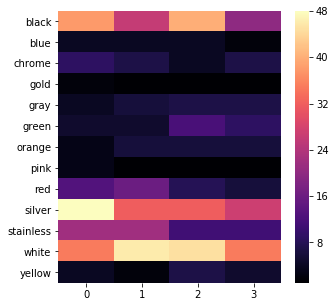

In [752]:
plt.figure(figsize=(5,5))
sns.heatmap(df, cmap='magma')

silver, black and white are most frequenly found colors in better sales ranks

centrifugal, citrus and masticating juicers have smilar distributions in terms of sales rank

In [802]:
df_all.pivot_table(index='category', values='sales_rank')

,sales_rank
category,
centrifugal,667612.715909
citrus,676640.916256
masticating,582399.244966


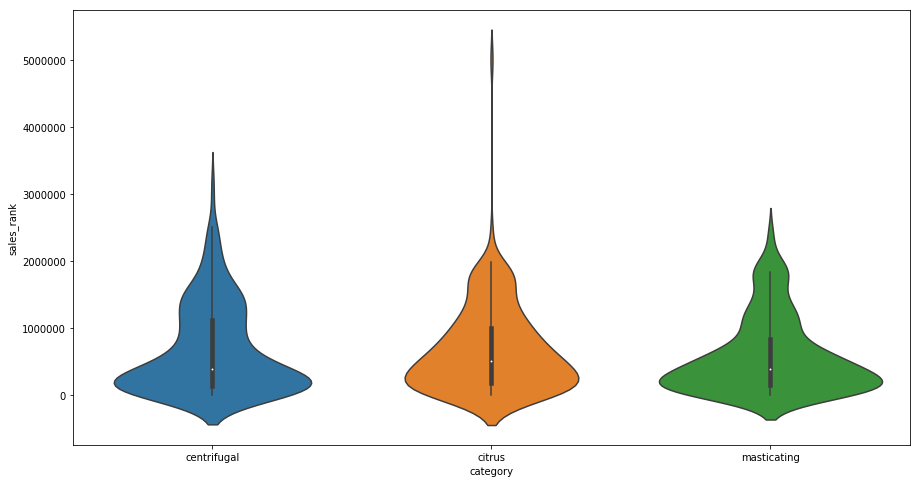

In [801]:
plt.figure(figsize=(15,8))
sns.violinplot(x='category', y='sales_rank', data=df_all)

### Feature Engineering

Determine brand distributions for each sales rank category

In [758]:
serilist = []
for i in range(4):
    brands = df_all.loc[colr_srank_qcut[colr_srank_qcut == str(i)].index.tolist()]['brand'].values.tolist()
    color_freq = dict(Counter(brands))
    serilist.append(pd.Series(color_freq))
df = pd.concat(serilist, axis=1)

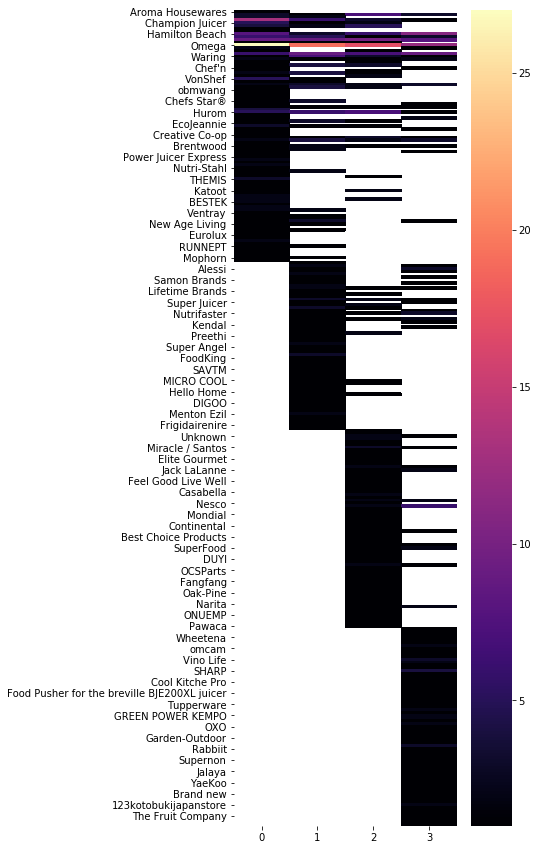

In [799]:
plt.figure(figsize=(5,15))
sns.heatmap(df, cmap='magma')

As clearly seen Omega brand is in the best position.

Get the top 10 brands and convert them into dummy variables

In [760]:
top_brand_list = df.sort_values(by=0, ascending=False).index.tolist()[:10]

In [761]:
arr_brand_dummy = np.zeros(df_all.shape[0] * len(top_brand_list)).reshape(df_all.shape[0], len(top_brand_list))
df_brand_dummy = pd.DataFrame(arr_brand_dummy, columns=top_brand_list, index=df_all.index)

,Omega,Breville,Kuvings,Hamilton Beach,Tribest,Juiceman,Hurom,VonShef,Champion Juicer,Cuisinart
B00004R93U,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B00004R93V,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B00004S8FH,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B00004S8FI,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B00004S8FJ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [762]:
for row in df_all.iterrows():
    b = row[1]['brand']
    if type(b) == str:
        df_brand_dummy.loc[row[0]][row[1]['brand']] = 1

In [803]:
df_brand_dummy.head()

,Omega,Breville,Kuvings,Hamilton Beach,Tribest,Juiceman,Hurom,VonShef,Champion Juicer,Cuisinart
B00004R93U,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
B00004R93V,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
B00004S8FH,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B00004S8FI,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B00004S8FJ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Get the top 10 colors and convert them into dummy variables

In [764]:
arr_color_dummy = np.zeros(df_all.shape[0] * len(top_color_list)).reshape(df_all.shape[0], len(top_color_list))
df_color_dummy = pd.DataFrame(arr_color_dummy, columns=top_color_list, index=df_all.index)

,black,blue,chrome,gold,gray,green,orange,pink,red,silver,stainless,white,yellow
B00004R93U,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B00004R93V,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B00004S8FH,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B00004S8FI,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B00004S8FJ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [765]:
for row in df_all.iterrows():
    c = row[1]['color']
    if type(c) == str:
        colors = list(set(top_color_list).intersection(set(re.split(" |/|-|\.|,|\&", c))))
        df_color_dummy.loc[row[0]][colors] = 1

In [766]:
df_color_dummy.head()

,black,blue,chrome,gold,gray,green,orange,pink,red,silver,stainless,white,yellow
B00004R93U,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
B00004R93V,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
B00004S8FH,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
B00004S8FI,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
B00004S8FJ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


Create dummy variables for the category column, too

In [767]:
cat_dummy = pd.get_dummies(df_all['category'])

In [768]:
cat_dummy.head()

,centrifugal,citrus,masticating
B00004R93U,1,0,0
B00004R93V,1,0,0
B00004S8FH,1,0,0
B00004S8FI,0,1,0
B00004S8FJ,0,1,0


Now it is time to create target!

In [770]:
target_sales_rank = pd.Series(np.zeros(df_all.shape[0]), index=df_all.index, name='target_sales_rank')

In [771]:
findex = colr_srank_qcut[colr_srank_qcut == '0'].index

In [772]:
target_sales_rank[findex] = 1

In [773]:
target_sales_rank.head()

B00004R93U    0.0
B00004R93V    0.0
B00004S8FH    0.0
B00004S8FI    0.0
B00004S8FJ    0.0
Name: target_sales_rank, dtype: float64

Create the final DataFrame:

In [774]:
df_final = pd.concat([cat_dummy, df_brand_dummy, df_color_dummy, df_all['price'], target_sales_rank], axis=1)
df_final.head()

,centrifugal,citrus,masticating,Omega,Breville,Kuvings,Hamilton Beach,Tribest,Juiceman,Hurom,...,green,orange,pink,red,silver,stainless,white,yellow,price,target_sales_rank
B00004R93U,1,0,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,158.98,0.0
B00004R93V,1,0,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,79.95,0.0
B00004S8FH,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,360.00,0.0
B00004S8FI,0,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,NaN,0.0
B00004S8FJ,0,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,149.99,0.0


In [775]:
#df_final.fillna(-9999, inplace=True)
df_final.dropna(inplace=True)
df_final.shape

(953, 28)

### Working on the models

Get input variables and output target

In [776]:
X = df_final.drop('target_sales_rank', axis=1)
y = df_final['target_sales_rank']

Split train and test data

In [777]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

Use the following models

In [808]:
lm = linear_model
models = {
    'Logistic Regression': lm.LogisticRegression, 
    'Logistic Regression CV': lm.LogisticRegressionCV, 
    'Ridge': lm.RidgeClassifier, 
    'Random Forest': RandomForestClassifier, 
    'KNN': KNeighborsClassifier
}

Run a loop to test all the models, and list sorted scores

In [810]:
scores = {}
for name, model in models.items():
    clf = model()
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    scores.update({name: score})

sorted_scores = sorted(scores.items(), key=operator.itemgetter(1), reverse=True)
print(sorted_scores)

[('Logistic Regression CV', 0.81151832460732987), ('Logistic Regression', 0.80628272251308897), ('Ridge', 0.80628272251308897), ('Random Forest', 0.77486910994764402), ('KNN', 0.76963350785340312)]


Find the feature importance values for the best model Logistic Regression CV

In [811]:
clf = linear_model.LogisticRegressionCV()
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.81151832460732987

In [783]:
#https://stackoverflow.com/questions/34052115/how-to-find-the-importance-of-the-features-for-a-logistic-regression-model
importance_arr = np.std(X, 0).reshape(1, X.shape[1])*clf.coef_
featurelist = X.columns.tolist()
importance = {}
for i, imp in enumerate(importance_arr[0]):
    importance.update({featurelist[i]: imp})
    
ordered_importance = sorted(importance.items(), key=operator.itemgetter(1), reverse=True)

C:\Users\plc03\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  


In [784]:
ordered_importance

[('Omega', 0.36034190825623374),
 ('silver', 0.28213377438536991),
 ('stainless', 0.26199936922123251),
 ('white', 0.21836068214363968),
 ('black', 0.20826599715359734),
 ('Breville', 0.20115467072109164),
 ('VonShef', 0.18337606293582928),
 ('Champion Juicer', 0.18022407208561336),
 ('chrome', 0.13514005233476509),
 ('Tribest', 0.12756965693398106),
 ('red', 0.12055241814523275),
 ('Kuvings', 0.11847716738443988),
 ('Hurom', 0.10561853571884749),
 ('blue', 0.094802618620986184),
 ('Cuisinart', 0.094468075619355038),
 ('gold', 0.085835293563222961),
 ('yellow', 0.082709545860265563),
 ('pink', 0.075994203215242098),
 ('Hamilton Beach', 0.06741973270091324),
 ('Juiceman', 0.054801367120626027),
 ('masticating', 0.046902653848331921),
 ('orange', 0.023746514182864706),
 ('centrifugal', -0.0085268870433292156),
 ('gray', -0.1042835671153632),
 ('citrus', -0.11618674587682118),
 ('green', -0.12076008321113825),
 ('price', -0.66891205742303306)]

### Conclution

As clearly seen the biggest influencer is the price. It is not surprising, right! Lower price is a means of getting better sales rank in juicer market, too.
As for the brand Omega is the number one. The company has been in the market for a long period of time and has lots of successfull products. They clearly have credibility and trust on the customers.
In terms of color, silver and stainless steel seems still the most demanding features. Worth to mention that the black and white options are close to them.
As I guess in the beginning, when I draw the distributions of juicer categories, they don't have much influence on the sales sales rank.
A final note: If Omega develops a new juicer in any category with silver color and low price, the success is guarantee :)